# Import

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

from PIL import Image

%matplotlib inline

# Fucntions

In [2]:
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['test'] = torch.utils.data.Subset(dataset, test_idx)
    
    return datasets

def show_img(data, size=8, shape=(4,2), pred=False):
    images_tensor, labels_tensor = data
    images_tensor, labels_tensor = images_tensor[:size], labels_tensor[:size]
    
    plt.figure(figsize=(10,10))
    row, col = shape
    for i, im in enumerate(images_tensor):
        images_tensor[i] = inv_normalize(im)
        images_numpy = np.array(images_tensor[i].permute(1,2,0))
        class_name = label_to_name[labels_tensor[i].item()]
        
        plt.subplot(row, col, i+1)
        plt.axis('off')
        plt.imshow(images_numpy)
        plt.title(class_name)

# Parameters

In [3]:
EPOCH = 60
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.20
LEARNING_RATE = 0.001
MOMENTUM = 0.9

# Datasets
- Dataset : caffe drinks
- Normalized

Name of Class :  ['americano', 'cappuccino', 'latte_greentea', 'latte_Strawberry']
Number of class :  4
Number of Train image :  1540
Number of Test image :  386
Label to Name :  {0: 'americano', 1: 'cappuccino', 2: 'latte_Strawberry', 3: 'latte_greentea'}


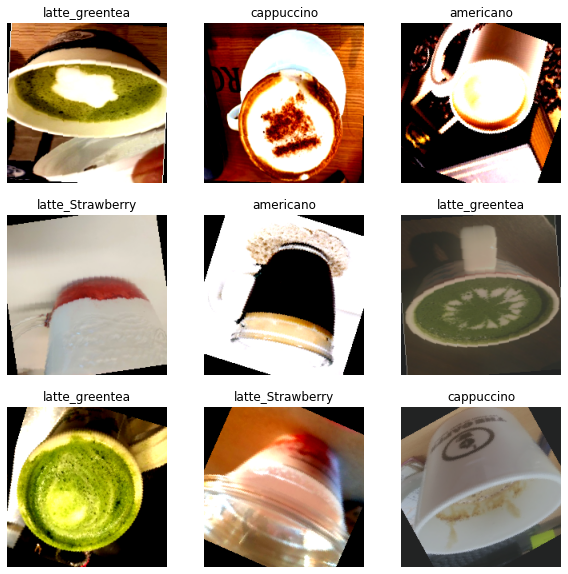

In [4]:
transform = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomAffine(30),
    transforms.ColorJitter(contrast=(0.2, 3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

data_path = '../../data/caffe_drinks/'
print('Name of Class : ', os.listdir(data_path))
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
datasets = train_test_dataset(dataset, test_split=TEST_SIZE)

trainloader = torch.utils.data.DataLoader(datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(datasets['test'], batch_size=TEST_BATCH_SIZE, shuffle=True)

CLASS_NUM = len(os.listdir(data_path))
print('Number of class : ', CLASS_NUM)
print('Number of Train image : ', len(datasets['train']))
print('Number of Test image : ', len(datasets['test']))

label_to_name = {v:k for k,v in dataset.class_to_idx.items()}
print('Label to Name : ', label_to_name)

show_img(iter(trainloader).next(), size=9, shape=(3,3))   

# Model
- VGG16
- Transfer Learning

In [5]:
# Models
model_vgg16 = torchvision.models.vgg16(pretrained=True)

for p in model_vgg16.features.parameters():
    p.requires_grad = False
    
model_vgg16.classifier[6] = nn.Linear(4096, CLASS_NUM)
model_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)

# Set GPU

In [6]:
# GPU 여부
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('We are using GPU')
else:
    device = torch.device('cpu')
    print('We are using CPU')

We are using GPU


# Loss Function & Optimizer

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Model Test
- Checking Code

In [8]:
# Model Test
with torch.no_grad():
    model_vgg16.eval()
    
    model_vgg16.to(device)
    ex_img, ex_label = iter(trainloader).next()
    ex_img, ex_label = ex_img.to(device), ex_label.to(device)
    ex_output = model_vgg16(ex_img)
    
    print(ex_img.size())
    print(ex_output.max(1))

torch.Size([32, 3, 200, 200])
torch.return_types.max(
values=tensor([ 0.1697,  0.1431,  0.2281,  0.2233,  0.1730,  0.2401,  0.3986,  0.3857,
         0.0215,  0.5288,  0.3428,  0.3559,  0.3920,  0.5517,  0.3103,  0.3177,
         0.6312,  0.1843,  0.8464,  1.0942,  0.0033,  0.2619,  0.2290,  0.2607,
        -0.0241,  0.5473,  0.7705,  0.2984, -0.0971,  0.4553, -0.1084,  0.1839],
       device='cuda:0'),
indices=tensor([1, 2, 0, 1, 0, 3, 3, 3, 3, 3, 2, 2, 3, 3, 0, 2, 2, 3, 3, 3, 1, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2], device='cuda:0'))


# Training

In [9]:
import time
import datetime

print('Start Training------------------')

loss_for_epoch = []
for e in range(EPOCH):
    start_time = time.time()
    
    model_vgg16.train()
    model_vgg16.to(device)
    
    running_loss = 0
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_vgg16(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        now = time.time()
        print('\rEpoch : [%d/%d]----- Iter : [%d/%d] ----- LOSS : %.3f------ Time : %d' 
              %(e+1, EPOCH, i+1, len(trainloader), running_loss, now - start_time), end='')
        
    loss_for_epoch.append(running_loss)
    print('\n')
print('Finish Training------------------')

Start Training------------------
Epoch : [1/60]----- Iter : [49/49] ----- LOSS : 36.667------ Time : 10

Epoch : [2/60]----- Iter : [49/49] ----- LOSS : 21.171------ Time : 10

Epoch : [3/60]----- Iter : [49/49] ----- LOSS : 17.123------ Time : 10

Epoch : [4/60]----- Iter : [49/49] ----- LOSS : 16.123------ Time : 10

Epoch : [5/60]----- Iter : [49/49] ----- LOSS : 15.186------ Time : 10

Epoch : [6/60]----- Iter : [49/49] ----- LOSS : 13.628------ Time : 10

Epoch : [7/60]----- Iter : [49/49] ----- LOSS : 13.338------ Time : 10

Epoch : [8/60]----- Iter : [49/49] ----- LOSS : 12.099------ Time : 10

Epoch : [9/60]----- Iter : [49/49] ----- LOSS : 10.517------ Time : 10

Epoch : [10/60]----- Iter : [49/49] ----- LOSS : 10.594------ Time : 10

Epoch : [11/60]----- Iter : [49/49] ----- LOSS : 9.383------ Time : 10

Epoch : [12/60]----- Iter : [49/49] ----- LOSS : 9.258------ Time : 10

Epoch : [13/60]----- Iter : [49/49] ----- LOSS : 9.284------ Time : 10

Epoch : [14/60]----- Iter : [4

# Test

In [11]:
correct = 0
total = 0
model_vgg16.eval()

with torch.no_grad():
    model_vgg16.to(device)
    for i, data in enumerate(testloader):
        test_images, test_labels = data
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        
        test_outputs = model_vgg16(test_images)
        pred = test_outputs.argmax(dim=1, keepdim=True)
        total += pred.size()[0]
        correct += pred.eq(test_labels.view_as(pred)).sum().item()

acc = correct / total * 100
print('The Accuracy of Model is %0.2f%%' % (correct / total * 100))

The Accuracy of Model is 91.97%


# Save Model

In [13]:
# Save Model
torch.save(model_vgg16.cpu().state_dict(), os.getcwd() + '/weights/trained_model_epoch{}_acc{}_class{}.pth'.format(EPOCH, acc, CLASS_NUM))

['americano', 'latte_greentea', 'latte_Strawberry', 'cappuccino']


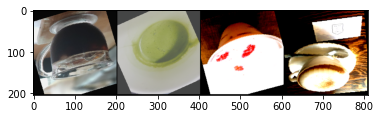

In [40]:
model_vgg16.eval()
with torch.no_grad():
    ex_img, ex_label = iter(testloader).next()
    model_vgg16.to(device)
    ex_img = ex_img.to(device)
    output = model_vgg16(ex_img)
    ex_img = ex_img.to('cpu')
ex_pred = output.argmax(axis=1)

from torchvision.utils import make_grid

for i, im in enumerate(ex_img):
    ex_img[i] = inv_normalize(ex_img[i])
img_grid = make_grid(ex_img).permute(1,2,0)
plt.imshow(img_grid)
output_name = [label_to_name[a.item()] for a in ex_label]
print(output_name)

In [43]:
confusion_matrix = torch.zeros(CLASS_NUM, CLASS_NUM)
with torch.no_grad():
    model_vgg16.to(device)
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
result = confusion_matrix.diag()/confusion_matrix.sum(1)

print('--------Accuracy of Each Class--------')
for name, acc in zip(label_to_name.values(), result):
    print('%s : %0.2f%%' %(name, acc * 100))

tensor([[98.,  9.,  1.,  3.],
        [ 4., 85.,  3.,  1.],
        [ 0.,  3., 86.,  0.],
        [ 3., 10.,  2., 78.]])
